<a href="https://colab.research.google.com/github/pranavmicro7/Denoising-on-CIFAR-10-Dataset/blob/master/CIFAR_10_noise_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**


In [1]:
#Importing Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import shutil
from keras.datasets import cifar10
from keras.applications import VGG16
from keras.layers import Dense,Conv2D,UpSampling2D,Input,BatchNormalization,MaxPooling2D,SpatialDropout2D,Conv2DTranspose
from keras import models,layers,optimizers
from keras.preprocessing.image import ImageDataGenerator
import os
from skimage.transform import resize
from keras.layers.core import Dropout, Lambda


Using TensorFlow backend.


**Downloading CIFAR-10 Dataset**


In [2]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


--2020-07-18 17:23:19--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  47.9MB/s    in 3.6s    

2020-07-18 17:23:23 (45.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

170500096/170498071 [==============================] - 4s 0us/step


**Dataset Sample Visualization**

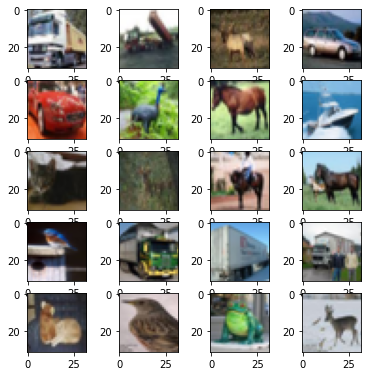

In [3]:
columns = 4
rows = 5
fig=plt.figure(figsize=(6.3, 6.3))

for i in range(1, columns*rows +1):
    img = x_train[i,:,:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Adding Gaussian Noise


In [4]:
x_test = x_test.astype('float32')
x_test /= 255
noise_factor = 0.1
autoencoder_x = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

autoencoder_x = np.clip(autoencoder_x, 0., 1.)

autoencoder_y=[]

for i in range(len(x_test)):
  #print(i)
  img=x_test[i,:,:,:]


  autoencoder_y.append(img) 

**Visualizing Noised Images**

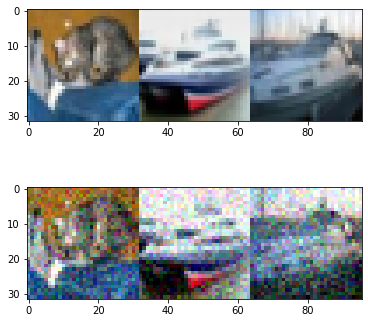

In [5]:
org1=autoencoder_y[0]
noised1=autoencoder_x[0]

org2=autoencoder_y[1]
noised2=autoencoder_x[1]

org3=autoencoder_y[2]
noised3=autoencoder_x[2]

original = np.concatenate((org1, org2, org3), axis=1)
noised = np.concatenate((noised1, noised2, noised3), axis=1)

fig=plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(original)
ax2 = fig.add_subplot(2,1,2)
ax2.imshow(noised)

In [6]:
#Reshaping the train and test set to feed into autoencoder
autoencoder_x=np.array(autoencoder_x)
autoencoder_y=np.array(autoencoder_y)

autoencoder_x=np.reshape(autoencoder_x,(10000,32,32,3))
autoencoder_y=np.reshape(autoencoder_y,(10000,32,32,3))

print(np.shape(autoencoder_x))
print(np.shape(autoencoder_y))



(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
#Autoencoder

#Encoder
input_ = Input(shape=(32,32,3))

#s = Lambda(lambda x: x / 255) (input_)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x=BatchNormalization()(x)
x1 = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu',  padding='same')(x1)
x=BatchNormalization()(x)
x2 = MaxPooling2D((2, 2))(x)


x = Conv2D(32, (3, 3), activation='relu',  padding='same')(x2)
x=BatchNormalization()(x)
x=layers.add([x2,x])
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=layers.add([x1,x])
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu',padding='same')(x)
#decoded=layers.add([input_,decoded])


autoencoder = models.Model(input_ ,decoded)
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam') 

history_autoencoder=autoencoder.fit(autoencoder_x,autoencoder_y,batch_size=16,epochs=50, shuffle=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

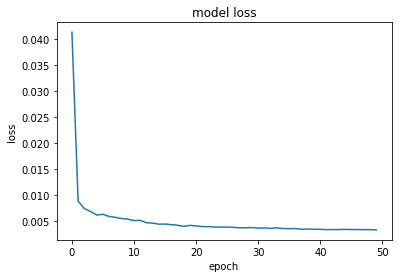

In [8]:
plt.plot(history_autoencoder.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


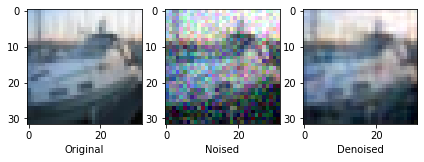

In [44]:

img=autoencoder_y[2]

noise_factor = 0.1
img_noise = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 

img_noise = np.clip(img_noise, 0., 1.)

img_noise=np.reshape(img_noise,(1,32,32,3))

ypred=autoencoder.predict(img_noise)

ypred=np.reshape(ypred,(32,32,3))


img_noise=np.reshape(img_noise,(32,32,3))



fig=plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel('Original')
ax1.imshow(img) 
ax2 = fig.add_subplot(1,3,3)
ax2.set_xlabel('Denoised')
ax2.imshow(ypred)
ax3 = fig.add_subplot(1,3,2)
ax3.set_xlabel('Noised')
ax3.imshow(img_noise)



## Adding Noise in the form of Colored Lines


In [32]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_line = np.copy(x_test)
for i in range(len(x_test)):
  for j in range(2):
    start=np.random.randint(5,15)
    end=start
    col = [np.random.randint(256),np.random.randint(256),np.random.randint(256)]
    for k in range(3):
      for l in range(6):
       x_x_train_linetest_line[i,:,:,k][start+l, end] = col[k]

    col = [np.random.randint(256),np.random.randint(256),np.random.randint(256)]
    for k in range(3):
      for l in range(6):  
       x_train_line[i,:,:,k][start+10, end+l] = col[k]

x_train_line = x_train_line.astype('float32')
x_train_line /= 255       


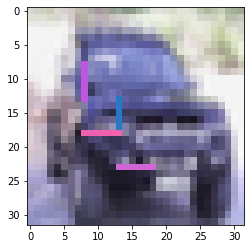

In [33]:
plt.imshow(x_train_line[9].astype('float32'))

In [34]:
#Reshaping the train and test set to feed into autoencoder
org=x_test
x_train_line=np.array(x_train_line)
org=np.array(org)

x_train_line=np.reshape(x_train_line,(10000,32,32,3))
org=np.reshape(org,(10000,32,32,3))

print(np.shape(x_train_line))
print(np.shape(org))

(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [37]:
#Autoencoder

#Encoder
input_ = Input(shape=(32,32,3))

#s = Lambda(lambda x: x / 255) (input_)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x=BatchNormalization()(x)
x1 = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu',  padding='same')(x1)
x=BatchNormalization()(x)
x2 = MaxPooling2D((2, 2))(x)


x = Conv2D(32, (3, 3), activation='relu',  padding='same')(x2)
x=BatchNormalization()(x)
x=layers.add([x2,x])
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=layers.add([x1,x])
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu',padding='same')(x)
#decoded=layers.add([input_,decoded])


autoencoder_2 = models.Model(input_ ,decoded)
autoencoder_2.summary()

autoencoder_2.compile(loss='mse', optimizer='adam') 

history_autoencoder_2=autoencoder_2.fit(x_train_line,org,batch_size=8,epochs=100, shuffle=True)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 32, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 32)   128         conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

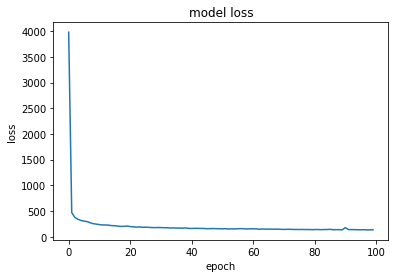

In [42]:
plt.plot(history_autoencoder_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

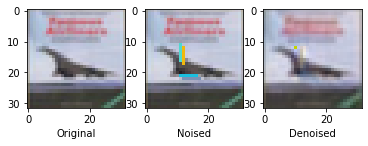

In [46]:

img=org[3]

img_noise=x_test_line[3]


img_noise=np.reshape(img_noise,(1,32,32,3))

ypred=autoencoder_2.predict(img_noise)

ypred=np.reshape(ypred,(32,32,3))


img_noise=np.reshape(img_noise,(32,32,3))



fig=plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel('Original')
ax1.imshow(img) 
ax2 = fig.add_subplot(1,3,3)
ax2.set_xlabel('Denoised')
ax2.imshow(ypred.astype('uint8'))
ax3 = fig.add_subplot(1,3,2)
ax3.set_xlabel('Noised')
ax3.imshow(img_noise)
